# Final Project
# Kalman Filter with a SEIRD Model for Disease Progression Predictions
# Ricca Callis
# EN 625.641.82.SU20 Introduction to Stochastic Differential Equations
# 12/6/2020

## Code


In [1]:
pip install filterpy

     |████████████████████████████████| 184kB 1.5MB/s eta 0:00:01
  Created wheel for filterpy: filename=filterpy-1.4.5-cp37-none-any.whl size=110452 sha256=46933ef2858395a1aa65dd542d2741d6e4e64f4db4a95cd2c2aee79e1244575b
  Stored in directory: /Users/riccacallis/Library/Caches/pip/wheels/c3/0c/dd/e92392c3f38a41371602d99fc77d6c1d42aadbf0c6afccdd02
Successfully built filterpy
Note: you may need to restart the kernel to use updated packages.


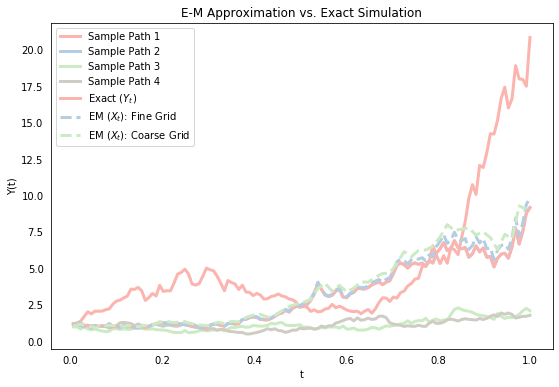

In [4]:
# Author: Ricca Callis
# EEN 625.641.82.SU20 Introduction to Stochastic Differential Equations
# Final Project: Kalman Filter with SIER Disease Model
# Date: 12/6/2020
# File name: KalmanFilerSEIR - Callis.ipynb
# Python Version: 3.7.5
# Jupyter Notebook: 6.0.1
# Description: Code for final project

# Kalman Filter Libraries
import numpy as np
from numpy import dot, zeros, eye
import pandas as pd
import random
import math import log, exp, sqrt
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from filterpy.stats import logpdf
from filterpy.common import pretty_str, reshape_z
import matplotlib.pyplot as plt
from copy import deepcopy
import sys
import scipy.linalg as linalg



# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
pal = ["#FBB4AE","#B3CDE3", "#CCEBC5","#CFCCC4"]

# SDE model parameters
mu, sigma, X0 = 2, 1, 1

# Simulation parameters
T, N = 1, 2**7
dt = 1.0 / N
t = np.arange(dt, 1 + dt, dt)  # Start at dt because Y = X0 at t = 0

# Initiate plot object
plt.title('Sample Solution Paths for Geometric Brownian Motion')
plt.ylabel('Y(t)'); plt.xlabel('t')

# Create and plot sample paths
for i in range(len(pal)):
    
    # Create Brownian Motion
    np.random.seed(i)
    dB = np.sqrt(dt) * np.random.randn(N)
    B  = np.cumsum(dB)
    
    # Compute exact solution
    Y = X0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * B)
    
    # Add line to plot
    plt.plot(t, Y, label = "Sample Path " + str(i+1), color=pal[i])

# Add legend
plt.legend(loc = 2);
    
    
# Create Brownian Motion
np.random.seed(1)
dB = np.sqrt(dt) * np.random.randn(N)
B  = np.cumsum(dB)

# Exact Solution
Y = X0 * np.exp((mu - 0.5*sigma**2)*t + (sigma * B))

# EM Approximation - small dt
X_em_small, X = [], X0
for j in range(N):  
    X += mu*X*dt + sigma*X*dB[j]
    X_em_small.append(X)

# EM Approximation - big dt
X_em_big, X, R = [], X0, 2
coarse_grid = np.arange(dt,1+dt,R*dt)
for j in range(int(N/R)):
    X += mu*X* (R*dt) + sigma*X*sum(dB[R*(j-1):R*j])
    X_em_big.append(X)    
    
# Plot
plt.plot(t, Y, label="Exact ($Y_t$)", color=pal[0])
plt.plot(t, X_em_small, label="EM ($X_t$): Fine Grid", color=pal[1], ls='--')
plt.plot(coarse_grid, X_em_big, label="EM ($X_t$): Coarse Grid", color=pal[2], ls='--')
plt.title('E-M Approximation vs. Exact Simulation'); plt.xlabel('t'); plt.legend(loc = 2);

In [ ]:
# Implement an extended Kalman Filter
class ExtendedKalmanFilter(object):

    """ Implements an extended Kalman filter (EKF).

    Parameters
    ----------
    dim_x : int
        Number of state variables for the Kalman filter. For example, if
        you are tracking the position and velocity of an object in two
        dimensions, dim_x would be 4.
        This is used to set the default size of P, Q, and u
    dim_z : int
        Number of of measurement inputs. For example, if the sensor
        provides you with position in (x,y), dim_z would be 2.
        
    Attributes
    ----------
    x : numpy.array(dim_x, 1)
        State estimate vector
        
    P : numpy.array(dim_x, dim_x)
        Covariance matrix
        
    x_prior : numpy.array(dim_x, 1)
        Prior (predicted) state estimate. The *_prior and *_post attributes
        are for convienence; they store the  prior and posterior of the
        current epoch. Read Only.
        
    P_prior : numpy.array(dim_x, dim_x)
        Prior (predicted) state covariance matrix.
        
    x_post : numpy.array(dim_x, 1)
        Posterior (updated) state estimate.
        
    P_post : numpy.array(dim_x, dim_x)
        Posterior (updated) state covariance matrix.
        
    R : numpy.array(dim_z, dim_z)
        Measurement noise matrix
        
    Q : numpy.array(dim_x, dim_x)
        Process noise matrix
        
    F : numpy.array()
        State Transition matrix
        
    H : numpy.array(dim_x, dim_x)
        Measurement function
        
    y : numpy.array
        Residual of the update step.
        
    K : numpy.array(dim_x, dim_z)
        Kalman gain of the update step.
        
    S :  numpy.array
        Systen uncertaintly projected to measurement space.
        
    z : ndarray
        Last measurement used in update().
        
    log_likelihood : float
        log-likelihood of the last measurement.
        
    likelihood : float
        likelihood of last measurment. """ 
        
    def __init__(self, dim_x, dim_z, dim_u=0):

        self.dim_x = dim_x
        self.dim_z = dim_z
        self.dim_u = dim_u

        self.x = zeros((dim_x, 1)) # state
        self.P = eye(dim_x)        # uncertainty covariance
        self.B = 0                 # control transition matrix
        self.F = np.eye(dim_x)     # state transition matrix
        self.R = eye(dim_z)        # state uncertainty
        self.Q = eye(dim_x)        # process uncertainty
        self.y = zeros((dim_z, 1)) # residual

        z = np.array([None]*self.dim_z)
        self.z = reshape_z(z, self.dim_z, self.x.ndim)

        # gain and residual are computed during the innovation step. We
        # save them so that in case you want to inspect them for various
        # purposes
        self.K = np.zeros(self.x.shape) # kalman gain
        self.y = zeros((dim_z, 1))
        self.S = np.zeros((dim_z, dim_z))   # system uncertainty
        self.SI = np.zeros((dim_z, dim_z))  # inverse system uncertainty

        # identity matrix. Do not alter this.
        self._I = np.eye(dim_x)

        self._log_likelihood = log(sys.float_info.min)
        self._likelihood = sys.float_info.min
        self._mahalanobis = None

        # these will always be a copy of x,P after predict() is called
        self.x_prior = self.x.copy()
        self.P_prior = self.P.copy()

        # these will always be a copy of x,P after update() is called
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()

    def predict_update(self, z, HJacobian, Hx, args=(), hx_args=(), u=0):
        
        """ Performs the predict/update innovation of the extended Kalman
        filter.
        
        Parameters
        ----------
        z : np.array
            measurement for this step.
            If `None`, only predict step is perfomed.
            
        HJacobian : function
           function which computes the Jacobian of the H matrix (measurement
           function). Takes state variable (self.x) as input, along with the
           optional arguments in args, and returns H.
           
        Hx : function
            function which takes as input the state variable (self.x) along
            with the optional arguments in hx_args, and returns the measurement
            that would correspond to that state.
            
        args : tuple, optional, default (,)
            arguments to be passed into HJacobian after the required state
            variable.
            
        hx_args : tuple, optional, default (,)
            arguments to be passed into Hx after the required state
            variable.
            
        u : np.array or scalar
            optional control vector input to the filter.
        """

        if not isinstance(args, tuple):
            args = (args,)

        if not isinstance(hx_args, tuple):
            hx_args = (hx_args,)

        if np.isscalar(z) and self.dim_z == 1:
            z = np.asarray([z], float)

        F = self.F
        B = self.B
        P = self.P
        Q = self.Q
        R = self.R
        x = self.x

        H = HJacobian(x, *args)

        # predict step
        x = dot(F, x) + dot(B, u)
        P = dot(F, P).dot(F.T) + Q

        # save prior
        self.x_prior = np.copy(self.x)
        self.P_prior = np.copy(self.P)

        # update step
        PHT = dot(P, H.T)
        self.S = dot(H, PHT) + R
        self.SI = linalg.inv(self.S)
        self.K = dot(PHT, self.SI)

        self.y = z - Hx(x, *hx_args)
        self.x = x + dot(self.K, self.y)

        I_KH = self._I - dot(self.K, H)
        self.P = dot(I_KH, P).dot(I_KH.T) + dot(self.K, R).dot(self.K.T)

        # save measurement and posterior state
        self.z = deepcopy(z)
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()

        # set to None to force recompute
        self._log_likelihood = None
        self._likelihood = None
        self._mahalanobis = None

    def update(self, z, HJacobian, Hx, R=None, args=(), hx_args=(),
               residual=np.subtract):
        
        """ Performs the update innovation of the extended Kalman filter.
        
        Parameters
        ----------
        z : np.array
            measurement for this step.
            If `None`, posterior is not computed
            
        HJacobian : function
           function which computes the Jacobian of the H matrix (measurement
           function). Takes state variable (self.x) as input, returns H.
           
        Hx : function
            function which takes as input the state variable (self.x) along
            with the optional arguments in hx_args, and returns the measurement
            that would correspond to that state.
            
        R : np.array, scalar, or None
            Optionally provide R to override the measurement noise for this
            one call, otherwise  self.R will be used.
            
        args : tuple, optional, default (,)
            arguments to be passed into HJacobian after the required state
            variable. for robot localization you might need to pass in
            information about the map and time of day, so you might have
            `args=(map_data, time)`, where the signature of HCacobian will
            be `def HJacobian(x, map, t)`
            
        hx_args : tuple, optional, default (,)
            arguments to be passed into Hx function after the required state
            variable.
            
        residual : function (z, z2), optional
            Optional function that computes the residual (difference) between
            the two measurement vectors. If you do not provide this, then the
            built in minus operator will be used. You will normally want to use
            the built in unless your residual computation is nonlinear (for
            example, if they are angles)
        """

        if z is None:
            self.z = np.array([[None]*self.dim_z]).T
            self.x_post = self.x.copy()
            self.P_post = self.P.copy()
            return

        if not isinstance(args, tuple):
            args = (args,)

        if not isinstance(hx_args, tuple):
            hx_args = (hx_args,)

        if R is None:
            R = self.R
        elif np.isscalar(R):
            R = eye(self.dim_z) * R

        if np.isscalar(z) and self.dim_z == 1:
            z = np.asarray([z], float)

        H = HJacobian(self.x, *args)

        PHT = dot(self.P, H.T)
        self.S = dot(H, PHT) + R
        self.SI = linalg.inv(self.S)
        self.K = PHT.dot(self.SI)

        hx = Hx(self.x, *hx_args)
        self.y = residual(z, hx)
        self.x = self.x + dot(self.K, self.y)

        # P = (I-KH)P(I-KH)' + KRK' is more numerically stable
        # and works for non-optimal K vs the equation
        # P = (I-KH)P usually seen in the literature.
        I_KH = self._I - dot(self.K, H)
        self.P = dot(I_KH, self.P).dot(I_KH.T) + dot(self.K, R).dot(self.K.T)

        # set to None to force recompute
        self._log_likelihood = None
        self._likelihood = None
        self._mahalanobis = None

        # save measurement and posterior state
        self.z = deepcopy(z)
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()

    def predict_x(self, u=0):
        """
        Predicts the next state of X. 
        """
        self.x = dot(self.F, self.x) + dot(self.B, u)

    def predict(self, u=0):
        """
        Predict next state (prior) using the Kalman filter state propagation
        equations.
        
        Parameters
        ----------
        u : np.array
            Optional control vector. If non-zero, it is multiplied by B
            to create the control input into the system.
        """

        self.predict_x(u)
        self.P = dot(self.F, self.P).dot(self.F.T) + self.Q

        # save prior
        self.x_prior = np.copy(self.x)
        self.P_prior = np.copy(self.P)

    @property
    def log_likelihood(self):
        """
        log-likelihood of the last measurement.
        """

        if self._log_likelihood is None:
            self._log_likelihood = logpdf(x=self.y, cov=self.S)
        return self._log_likelihood

    @property
    def likelihood(self):
        """
        Computed from the log-likelihood. 
        """
        if self._likelihood is None:
            self._likelihood = exp(self.log_likelihood)
            if self._likelihood == 0:
                self._likelihood = sys.float_info.min
        return self._likelihood

    @property
    def mahalanobis(self):
        """
        Mahalanobis distance of innovation. E.g. 3 means measurement
        was 3 standard deviations away from the predicted value.
        Returns
        -------
        mahalanobis : float
        """
        if self._mahalanobis is None:
            self._mahalanobis = sqrt(float(dot(dot(self.y.T, self.SI), self.y)))
        return self._mahalanobis

    def __repr__(self):
        return '\n'.join([
            'KalmanFilter object',
            pretty_str('x', self.x),
            pretty_str('P', self.P),
            pretty_str('x_prior', self.x_prior),
            pretty_str('P_prior', self.P_prior),
            pretty_str('F', self.F),
            pretty_str('Q', self.Q),
            pretty_str('R', self.R),
            pretty_str('K', self.K),
            pretty_str('y', self.y),
            pretty_str('S', self.S),
            pretty_str('likelihood', self.likelihood),
            pretty_str('log-likelihood', self.log_likelihood),
            pretty_str('mahalanobis', self.mahalanobis)
            ])

In [ ]:
# Implement SEIR model

def seir (xin,pin) :
    #
    # assumption
    #
    '''
    - never infected twice
    - no pre-symptomatic transmission
    '''
    #
    # parameters
    # - p = [sigma,lamda,gamma,delta,mu].T
    #
    '''
    k       : incubation day
    beta    : infection rate
    lamba   : recovery rate (1/gamma = infection period; constant)
    mu      : recovery rate without experiencing symptom
    '''
    #
    # variables 
    # - x = [S,E,I,R,N].T
    # - dx = [nS,nE,nI].T
    #
    '''
    S : Susceptible
    E : Exposed
    I : Infected
    R : Recoverd
    N : Population
    '''
    Sin = xin[0]
    Ein = xin[1]
    Iin = xin[2]
    Rin = xin[3]
    Nin = xin[4]
    k     = pin[0]
    beta  = pin[1]
    lamba = pin[2]
    mu    = pin[3]
    #
    # time integration
    #
    nE = min(lambd * Iin * Sin, Sin)
    nI = sigma * Ein
    nD = delta * Iin
    Sout = Sin - nE
    Eout = Ein + nE - nI - nE2R
    Iout = Iin + nI - nI2R -nD
    Rout = Rin + nE2R + nI2R
    Nout = Sout + Eout + Iout + Rout + Dout
    #
    # update state but params
    #
    xout = np.array(xin)
    dx = np.empty(5,dtype=float)
    xout[0] = Sout
    xout[1] = Eout
    xout[2] = Iout
    xout[3] = Rout
    xout[5] = Nout
    dx  [0] = nS
    dx  [1] = nE
    dx  [2] = nI

    return (xout,dx)
#--------------------------------------
def update(xin,dx) :
    Sin = xin[0]
    Ein = xin[1]
    Iin = xin[2]
    Rin = xin[3]
    Nin = xin[5]
    nS   = dx[0]
    nE   = dx[1]
    nI   = dx[2]
    nE   = max(min(nE, Sin), 0)
    nI   = max(min(nI, Ein), 0)
    nD   = max(min(nD, Iin), 0)
    Sout = Sin - nE
    Eout = Ein + nE - nI - nE2R
    Iout = Iin + nI - nI2R - nD
    Rout = Rin + nE2R + nI2R
    Nout = Sout + Eout + Iout + Rout + Dout
    #
    # update 
    #
    xout = np.empty(np.shape(xin))
    xout[0] = max(Sout,0.)
    xout[1] = max(Eout,0.)
    xout[2] = max(Iout,0.)
    xout[3] = max(Rout,0.)
    xout[5] = max(Nout,0.)
    return (xout)